# MODEL

## Setup

In [39]:
import pandas as pd

df = pd.read_csv('/content/dataset_endometrio.csv')
print(f"Total pacientes iniciales: {len(df)}")

df_nsmp = df[
    (df['p53_ihq'] == 1) &
    (df['mut_pole'] == 2)
].copy()

print(f"Pacientes filtradas (Perfil NSMP): {len(df_nsmp)}")
print("Filtro aplicado correctamente.")

Total pacientes iniciales: 163
Pacientes filtradas (Perfil NSMP): 103
Filtro aplicado correctamente.


## Training

In [40]:
!pip install lifelines
import pandas as pd
import lifelines
from lifelines import CoxPHFitter

columnas_base = [
    'recidiva',
    'diferencia_dias_reci_exit',
    'est_pcte',
    'Grado',
    'afectacion_linf',
    'infiltracion_mi',
    'beta_cateninap'
]

df_temp = df[columnas_base].copy()

#limpieza de columnas
df_temp['beta_cateninap'] = pd.to_numeric(df_temp['beta_cateninap'], errors='coerce')
df_final_beta = df_temp[df_temp['beta_cateninap'].isin([0.0, 1.0])].dropna()
df_final_beta['beta_cateninap'] = df_final_beta['beta_cateninap'].astype(int)
df_final_beta = pd.get_dummies(df_final_beta, columns=['beta_cateninap'], drop_first=True, prefix='beta_cat')
columna_beta = 'beta_cat_1'

if columna_beta in df_final_beta.columns:
    columnas_finales_cox = [
        'recidiva',
        'diferencia_dias_reci_exit',
        'est_pcte',
        'Grado',
        'afectacion_linf',
        'infiltracion_mi',
        columna_beta
    ]
    df_modelo = df_final_beta[columnas_finales_cox].dropna()

    print(f"\n--- ESTADÍSTICAS DEL MODELO BETA-CATENINA REVISADO ---")
    print(f"Pacientes finales: {len(df_modelo)}")
    print(f"Eventos disponibles: {df_modelo['recidiva'].sum()}")
    cph_beta = CoxPHFitter(penalizer=0.1)

    try:
        cph_beta.fit(df_modelo, duration_col='diferencia_dias_reci_exit', event_col='recidiva')

        print("\n=== MODELO COX PENALIZADO (+ BETA-CATENINA) ===")
        cph_beta.print_summary()

        print("\n--- Importancia de las variables (Coeficientes) ---")
        print(cph_beta.params_.sort_values(key=abs, ascending=False))

    except Exception as e:
        print(f"Error al ajustar el modelo (Problema de matriz): {e}")

else:
    print(f"\n ALERTA: La columna de 'Beta Catenina Positiva' ({columna_beta}) NO se creó.")
    print("Esto significa que, tras filtrar las pacientes con datos completos en las variables clínicas,")
    print("ninguna de ellas tiene el resultado 'Positivo' (valor 1) para Beta-Catenina.")
    print("El modelo no puede evaluar el efecto de Beta-Catenina.")


--- ESTADÍSTICAS DEL MODELO BETA-CATENINA REVISADO ---
Pacientes finales: 91
Eventos disponibles: 21

=== MODELO COX PENALIZADO (+ BETA-CATENINA) ===


<lifelines.CoxPHFitter: fitted with 91 total observations, 74 right-censored observations>
             duration col = 'diferencia_dias_reci_exit'
                event col = 'recidiva'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 91
number of events observed = 17
   partial log-likelihood = -58.53
         time fit was run = 2025-12-14 10:33:50 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
est_pcte         1.63      5.09      0.54            0.57            2.68                1.77               14.60
Grado            0.54      1.72      0.59           -0.62            1.70                0.54                5.45
afectacion_linf  1.20      3.31      0.45            0.31            2.09                1.36                8.06
infiltracion_mi  0.21      1.23      0.27           -0.33            0.75                0.72                2.11
beta_cat_1       0.60      1.81      0.44           -0.26            1.45                0.77                4.28

                 cmp to    z      p  -log2(p)
covariate                                    
est_pcte           0.00 3.02 <0.005      8.65
Grado              0.00 0.92   0.36      1.47
afectacion_linf    0.00 2.63   0.01      6.88
infiltracion_mi    0.00 0.76   0.45      1.16
beta_cat_1         0.00 1.36   0.18      2.51
---
Concordance = 0.85
Partial AIC = 127.05
log-likelihood ratio test = 19.81 on 5 df
-log2(p) of ll-ratio test = 9.53


--- Importancia de las variables (Coeficientes) ---
covariate
est_pcte           1.626924
afectacion_linf    1.196324
beta_cat_1         0.595047
Grado              0.539688
infiltracion_mi    0.209032
Name: coef, dtype: float64


## Verification


Distribución de pacientes por Grupo de Riesgo (N=91):
grupo_riesgo
Bajo (Estadio I)        82
Alto (Estadio II-IV)     9
Name: count, dtype: int64


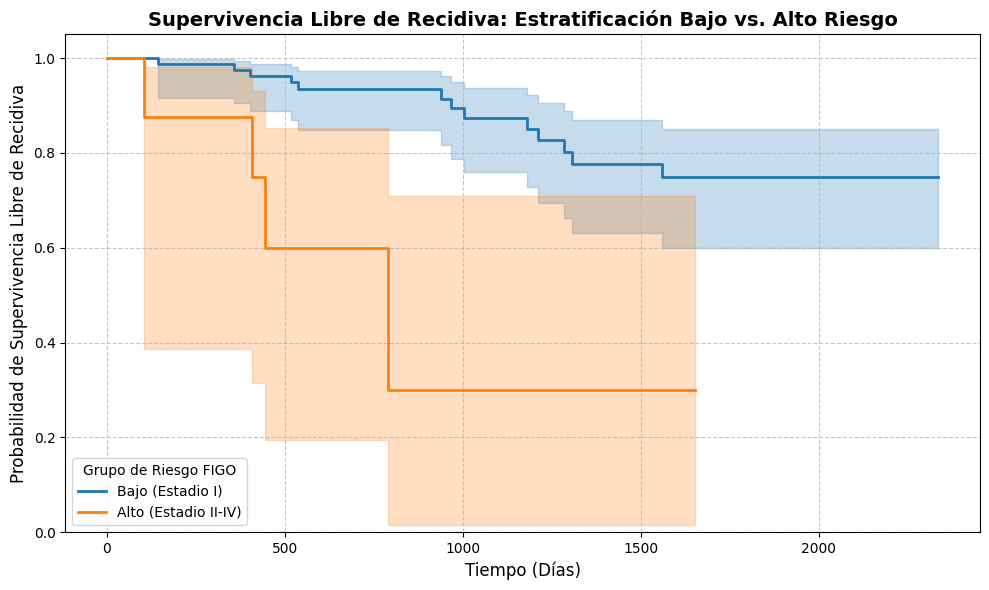


--- TEST DE LOG-RANK PARA VALIDAR LA SEPARACIÓN DE RIESGO ---


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          13.39 <0.005     11.95

In [41]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd

columnas_km = ['diferencia_dias_reci_exit', 'recidiva', 'est_pcte']
df_km = df_modelo[columnas_km].copy()

# Crear la nueva columna de agrupación de riesgo (Low vs High)
df_km['grupo_riesgo'] = df_km['est_pcte'].apply(
    lambda x: 'Bajo (Estadio I)' if x == 1 else 'Alto (Estadio II-IV)'
)
print(f"\nDistribución de pacientes por Grupo de Riesgo (N={len(df_km)}):")
print(df_km['grupo_riesgo'].value_counts())

# CURVAS
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(10, 6))

grupos = sorted(df_km['grupo_riesgo'].unique(), reverse=True)
curvas = {}

for grupo_nombre in grupos:
    subset = df_km[df_km['grupo_riesgo'] == grupo_nombre]
    kmf.fit(subset['diferencia_dias_reci_exit'], event_observed=subset['recidiva'], label=grupo_nombre)
    kmf.plot_survival_function(ax=ax, ci_show=True, linewidth=2)
    curvas[grupo_nombre] = subset

ax.set_title('Supervivencia Libre de Recidiva: Estratificación Bajo vs. Alto Riesgo', fontsize=14, fontweight='bold')
ax.set_xlabel('Tiempo (Días)', fontsize=12)
ax.set_ylabel('Probabilidad de Supervivencia Libre de Recidiva', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title="Grupo de Riesgo FIGO", loc='lower left')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


# Log-Rank Test
print("\n--- TEST DE LOG-RANK PARA VALIDAR LA SEPARACIÓN DE RIESGO ---")
T_bajo = curvas['Bajo (Estadio I)']['diferencia_dias_reci_exit']
E_bajo = curvas['Bajo (Estadio I)']['recidiva']

T_alto = curvas['Alto (Estadio II-IV)']['diferencia_dias_reci_exit']
E_alto = curvas['Alto (Estadio II-IV)']['recidiva']

# Test
results = logrank_test(T_bajo, T_alto, E_bajo, E_alto)
results.print_summary()

# VISUALIZER


## Constants & functions

In [42]:
import gradio as gr
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import base64
from pathlib import Path
from scipy.stats import norm

def image_to_base64(image_path):
    try:
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode()
    except:
        return None

COEFS = {
    "est_pcte": 1.6269,
    "afectacion_linf": 1.1963,
    "beta_cat_1": 0.5950,
    "Grado": 0.5397,
    "infiltracion_mi": 0.2090
}

Q25_THRESHOLD = 4.80
Q75_THRESHOLD = 6.45
MIN_SCORE_VISUAL = 2.0
MAX_SCORE_VISUAL = 11.0

SLR_VALORES = {"BAJO": 95, "INTERMEDIO": 82, "ALTO": 60}
SLR_TEXT = {"BAJO": "Baja Recurrencia", "INTERMEDIO": "Recurrencia Moderada", "ALTO": "Alta Recurrencia"}

COLORS = {
    "BAJO": "#43A047",
    "INTERMEDIO": "#FB8C00",
    "ALTO": "#E53935",
    "PRIMARY": "#2196F3",
    "SECONDARY": "#00ACC1"
}

In [43]:
def create_contribution_chart(estadio, grado, lvi, mi, beta_cat, risk_score, risk_cat_key):
    lvi_val = 1 if lvi == "Sí (Presente)" else 0
    mi_val = 1 if mi == "Sí (Profunda)" else 0
    beta_cat_val = 1 if beta_cat == "Positiva" else 0

    contributions = [
        {"Factor": f"Estadio FIGO ({estadio})", "Contribución": COEFS["est_pcte"] * estadio, "Tipo": "Patológico"},
        {"Factor": f"LVSI ({lvi_val})", "Contribución": COEFS["afectacion_linf"] * lvi_val, "Tipo": "Clínico"},
        {"Factor": f"Beta-Catenina ({beta_cat_val})", "Contribución": COEFS["beta_cat_1"] * beta_cat_val, "Tipo": "Molecular"},
        {"Factor": f"Grado ({grado})", "Contribución": COEFS["Grado"] * grado, "Tipo": "Patológico"},
        {"Factor": f"Infiltración MI ({mi_val})", "Contribución": COEFS["infiltracion_mi"] * mi_val, "Tipo": "Patológico"},
    ]

    df = pd.DataFrame(contributions).sort_values(by="Contribución", ascending=True)
    risk_color = COLORS.get(risk_cat_key, COLORS["PRIMARY"])

    type_colors = {"Patológico": "#2196F3", "Clínico": "#00ACC1", "Molecular": "#9C27B0"}

    fig = px.bar(
        df, x='Contribución', y='Factor', orientation='h',
        title=f'<b>Contribución de Factores al NEST Score</b> (Total: {risk_score:.2f})',
        color='Tipo',
        color_discrete_map=type_colors,
        text='Contribución'
    )

    fig.add_vline(
        x=risk_score,
        line_width=3,
        line_dash="dash",
        line_color=risk_color,
        annotation_text=f"<b>Score Total: {risk_score:.2f}</b>",
        annotation_position="top right",
        annotation=dict(bgcolor=risk_color, font=dict(color="white", size=13, family="Inter"))
    )

    fig.update_traces(
        texttemplate='<b>%{text:.2f}</b>',
        textposition='outside',
        textfont=dict(size=12, color="#424242", family="Inter"),
        marker=dict(line=dict(width=0))
    )

    fig.update_layout(
        yaxis_title="",
        xaxis_title="<b>Contribución Ponderada (Log-HR × Valor)</b>",
        showlegend=True,
        legend_title="<b>Tipo de Factor</b>",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, bgcolor="rgba(255,255,255,0.9)", bordercolor="#E0E0E0", borderwidth=1),
        height=400,
        margin=dict(l=180, r=60, t=80, b=60),
        paper_bgcolor="white",
        plot_bgcolor="white",
        font=dict(family="Inter, system-ui, sans-serif", size=12, color="#424242"),
        xaxis=dict(gridcolor="#F5F5F5", showgrid=True, zeroline=True, zerolinecolor="#E0E0E0"),
        yaxis=dict(gridcolor="#F5F5F5", showgrid=False)
    )

    return fig

def create_survival_curve(key):
    months = np.linspace(0, 36, 37)

    base_survival = {
        "BAJO": lambda t: 0.95 - (0.05 * (t/36)**2),
        "INTERMEDIO": lambda t: 0.82 - (0.18 * (t/36)**1.5),
        "ALTO": lambda t: 0.60 - (0.40 * (t/36)**1.2)
    }

    survival_data = []
    for risk_level in ["BAJO", "INTERMEDIO", "ALTO"]:
        for month in months:
            survival = base_survival[risk_level](month)
            survival_data.append({
                "Mes": month,
                "Supervivencia": max(0, min(1, survival)) * 100,
                "Categoría": f"Riesgo {risk_level}"
            })

    df = pd.DataFrame(survival_data)

    fig = go.Figure()

    for risk_level, color in zip(["BAJO", "INTERMEDIO", "ALTO"], [COLORS["BAJO"], COLORS["INTERMEDIO"], COLORS["ALTO"]]):
        df_risk = df[df["Categoría"] == f"Riesgo {risk_level}"]

        line_width = 4 if risk_level == key else 2
        opacity = 1.0 if risk_level == key else 0.4

        fig.add_trace(go.Scatter(
            x=df_risk["Mes"],
            y=df_risk["Supervivencia"],
            mode='lines',
            name=f"Riesgo {risk_level}",
            line=dict(color=color, width=line_width),
            opacity=opacity,
            hovertemplate='<b>%{fullData.name}</b><br>Mes: %{x}<br>Supervivencia: %{y:.1f}%<extra></extra>'
        ))

    fig.update_layout(
        title="<b>Curva de Supervivencia Libre de Recidiva (36 meses)</b>",
        xaxis_title="<b>Meses desde el diagnóstico</b>",
        yaxis_title="<b>Supervivencia (%)</b>",
        height=400,
        paper_bgcolor="white",
        plot_bgcolor="white",
        font=dict(family="Inter, system-ui, sans-serif", size=12, color="#424242"),
        xaxis=dict(gridcolor="#F5F5F5", showgrid=True),
        yaxis=dict(gridcolor="#F5F5F5", showgrid=True, range=[0, 105]),
        legend=dict(x=0.02, y=0.02, bgcolor="rgba(255,255,255,0.9)", bordercolor="#E0E0E0", borderwidth=1),
        hovermode='x unified'
    )

    return fig

def create_risk_distribution(risk_score, key):
    # Ya no hay importación local de norm aquí (está como estaba originalmente)

    x = np.linspace(MIN_SCORE_VISUAL, MAX_SCORE_VISUAL, 100)

    bajo_mean = (MIN_SCORE_VISUAL + Q25_THRESHOLD) / 2
    intermedio_mean = (Q25_THRESHOLD + Q75_THRESHOLD) / 2
    alto_mean = (Q75_THRESHOLD + MAX_SCORE_VISUAL) / 2

    bajo_std = (Q25_THRESHOLD - MIN_SCORE_VISUAL) / 3
    intermedio_std = (Q75_THRESHOLD - Q25_THRESHOLD) / 3
    alto_std = (MAX_SCORE_VISUAL - Q75_THRESHOLD) / 3

    # Asume que 'norm' fue importado globalmente
    bajo_dist = norm.pdf(x, bajo_mean, bajo_std)
    intermedio_dist = norm.pdf(x, intermedio_mean, intermedio_std)
    alto_dist = norm.pdf(x, alto_mean, alto_std)

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=x, y=bajo_dist,
        fill='tozeroy',
        name='Riesgo Bajo',
        line=dict(color=COLORS["BAJO"], width=2),
        fillcolor=f'rgba(67, 160, 71, 0.3)'
    ))

    fig.add_trace(go.Scatter(
        x=x, y=intermedio_dist,
        fill='tozeroy',
        name='Riesgo Intermedio',
        line=dict(color=COLORS["INTERMEDIO"], width=2),
        fillcolor=f'rgba(251, 140, 0, 0.3)'
    ))

    fig.add_trace(go.Scatter(
        x=x, y=alto_dist,
        fill='tozeroy',
        name='Riesgo Alto',
        line=dict(color=COLORS["ALTO"], width=2),
        fillcolor=f'rgba(229, 57, 53, 0.3)'
    ))

    fig.add_vline(
        x=risk_score,
        line_dash="dash",
        line_color=COLORS[key],
        line_width=3,
        annotation_text=f"Su Score: {risk_score:.2f}",
        annotation_position="top"
    )

    fig.update_layout(
        title="<b>Distribución de Riesgo en la Cohorte</b>",
        xaxis_title="<b>NEST Score</b>",
        yaxis_title="<b>Densidad de Probabilidad</b>",
        height=350,
        paper_bgcolor="white",
        plot_bgcolor="white",
        font=dict(family="Inter, system-ui, sans-serif", size=12, color="#424242"),
        xaxis=dict(gridcolor="#F5F5F5", showgrid=True),
        yaxis=dict(gridcolor="#F5F5F5", showgrid=True, showticklabels=False),
        legend=dict(x=0.7, y=0.95, bgcolor="rgba(255,255,255,0.9)", bordercolor="#E0E0E0", borderwidth=1),
        showlegend=True
    )

    return fig

## Calculator

In [44]:
def nest_calculator(estadio, grado, lvi, mi, beta_cat):
    try:
        estadio_val = int(str(estadio))
        grado_val = int(str(grado))
    except (ValueError, TypeError):
        error_html = '''
        <div style="background: #FFEBEE; border-left: 5px solid #E53935; padding: 24px; border-radius: 8px;">
            <div style="color: #E53935; font-size: 18px; font-weight: 700;">ERROR DE VALIDACIÓN</div>
            <div style="color: #424242; margin-top: 10px; font-size: 14px;">Por favor, selecciona valores válidos para todos los campos.</div>
        </div>
        '''
        return error_html, go.Figure(), go.Figure(), go.Figure()

    lvi_val = 1 if lvi == "Sí (Presente)" else 0
    mi_val = 1 if mi == "Sí (Profunda)" else 0
    beta_cat_val = 1 if beta_cat == "Positiva" else 0

    risk_score = (
        (COEFS["est_pcte"] * estadio_val) +
        (COEFS["Grado"] * grado_val) +
        (COEFS["afectacion_linf"] * lvi_val) +
        (COEFS["infiltracion_mi"] * mi_val) +
        (COEFS["beta_cat_1"] * beta_cat_val)
    )

    if risk_score <= Q25_THRESHOLD:
        key = "BAJO"
    elif risk_score <= Q75_THRESHOLD:
        key = "INTERMEDIO"
    else:
        key = "ALTO"

    color = COLORS[key]
    risk_cat = f"RIESGO {key}"
    slr_prob = SLR_VALORES[key]
    slr_text = SLR_TEXT[key]

    score_norm = max(0, min(1, (risk_score - MIN_SCORE_VISUAL) / (MAX_SCORE_VISUAL - MIN_SCORE_VISUAL)))
    indicator_pos = score_norm * 100

    q25_pos = ((Q25_THRESHOLD - MIN_SCORE_VISUAL) / (MAX_SCORE_VISUAL - MIN_SCORE_VISUAL)) * 100
    q75_pos = ((Q75_THRESHOLD - MIN_SCORE_VISUAL) / (MAX_SCORE_VISUAL - MIN_SCORE_VISUAL)) * 100

    html_result = f"""
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Inter:wght@400;500;600;700&display=swap');
        .nest-risk-panel {{
            font-family: 'Inter', -apple-system, sans-serif !important;
            background: white !important;
            padding: 32px !important;
            border-radius: 8px !important;
            border: 1px solid #E0E0E0 !important;
        }}
        .nest-risk-panel * {{
            color: inherit !important;
        }}
        .risk-header {{
            background: {color} !important;
            color: #FFFFFF !important;
            text-align: center !important;
            font-size: 24px !important;
            font-weight: 700 !important;
            padding: 16px !important;
            border-radius: 4px !important;
            margin-bottom: 24px !important;
            text-transform: uppercase !important;
            letter-spacing: 1px !important;
        }}
        .metric-row {{
            display: grid !important;
            grid-template-columns: 1fr 1fr !important;
            gap: 20px !important;
            margin-bottom: 24px !important;
        }}
        .metric-box {{
            background: white !important;
            padding: 20px !important;
            border-radius: 6px !important;
            border-left: 4px solid {color} !important;
            border: 2px solid #E0E0E0 !important;
        }}
        .metric-label {{
            font-size: 12px !important;
            font-weight: 700 !important;
            color: #424242 !important;
            text-transform: uppercase !important;
            letter-spacing: 0.5px !important;
            margin-bottom: 10px !important;
        }}
        .metric-value {{
            font-size: 42px !important;
            font-weight: 800 !important;
            color: {color} !important;
            line-height: 1 !important;
        }}
        .metric-unit {{
            font-size: 14px !important;
            color: #616161 !important;
            margin-top: 6px !important;
            font-weight: 600 !important;
        }}
        .risk-gauge {{
            height: 24px !important;
            border-radius: 12px !important;
            background: linear-gradient(to right,
                {COLORS["BAJO"]} 0%, {COLORS["BAJO"]} {q25_pos}%,
                {COLORS["INTERMEDIO"]} {q25_pos}%, {COLORS["INTERMEDIO"]} {q75_pos}%,
                {COLORS["ALTO"]} {q75_pos}%, {COLORS["ALTO"]} 100%) !important;
            position: relative !important;
            margin: 20px 0 32px 0 !important;
            box-shadow: inset 0 1px 3px rgba(0,0,0,0.15) !important;
        }}
        .indicator {{
            position: absolute !important;
            height: 36px !important;
            width: 3px !important;
            background: #212121 !important;
            top: -6px !important;
            left: {indicator_pos}% !important;
            margin-left: -1.5px !important;
            box-shadow: 0 2px 6px rgba(0,0,0,0.4) !important;
        }}
        .indicator::before {{
            content: '' !important;
            position: absolute !important;
            top: -6px !important;
            left: -4px !important;
            width: 0 !important;
            height: 0 !important;
            border-left: 5px solid transparent !important;
            border-right: 5px solid transparent !important;
            border-top: 8px solid #212121 !important;
        }}
        .gauge-labels {{
            display: flex !important;
            justify-content: space-between !important;
            font-size: 13px !important;
            color: #424242 !important;
            font-weight: 700 !important;
            margin-top: -20px !important;
        }}
        .gauge-labels span {{
            color: #424242 !important;
        }}
        .divider {{
            border: 0 !important;
            border-top: 1px solid #E0E0E0 !important;
            margin: 24px 0 !important;
        }}
        .footer-info {{
            margin-top: 20px !important;
            padding-top: 16px !important;
            border-top: 2px solid #E0E0E0 !important;
            font-size: 13px !important;
            color: #616161 !important;
            text-align: center !important;
            font-weight: 600 !important;
        }}
    </style>
    <div class="nest-risk-panel">
        <div class="risk-header">
            {risk_cat}
        </div>
        <div class="metric-row">
            <div class="metric-box">
                <div class="metric-label">NEST Score</div>
                <div class="metric-value">{risk_score:.2f}</div>
                <div class="metric-unit">Puntuación multivariada</div>
            </div>
            <div class="metric-box">
                <div class="metric-label">Supervivencia Libre Recidiva (3 años)</div>
                <div class="metric-value">{slr_prob}%</div>
                <div class="metric-unit">{slr_text}</div>
            </div>
        </div>
        <div class="risk-gauge">
            <div class="indicator"></div>
        </div>
        <div class="gauge-labels">
            <span>{MIN_SCORE_VISUAL:.1f} (Bajo)</span>
            <span>{MAX_SCORE_VISUAL:.1f} (Alto)</span>
        </div>
        <div class="footer-info">
            C-index: 0.85 | N=91 pacientes | Andres & Didac's team | Omar Cornejo & Rubén Palà
        </div>
    </div>
    """

    contribution_chart = create_contribution_chart(estadio_val, grado_val, lvi, mi, beta_cat, risk_score, key)
    survival_chart = create_survival_curve(key)
    distribution_chart = create_risk_distribution(risk_score, key)

    return html_result, contribution_chart, survival_chart, distribution_chart

## Styles

In [45]:
custom_css = """
@import url('https://fonts.googleapis.com/css2?family=Inter:wght@400;500;600;700;800&display=swap');

:root {
    color-scheme: light !important;
}

body {
    background: #FAFAFA !important;
}

.gradio-container {
    font-family: 'Inter', system-ui, sans-serif !important;
    max-width: 100% !important;
    margin: 0 !important;
    padding: 20px !important;
    background: #FAFAFA !important;
}

.main {
    max-width: 1600px !important;
    margin: 0 auto !important;
}

h1, h2, h3 {
    font-weight: 700 !important;
    color: #212121 !important;
}

label {
    font-weight: 600 !important;
}

button {
    font-weight: 600 !important;
    letter-spacing: 0.3px;
}

.logo-container {
    background: white;
    padding: 28px;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.06);
    margin-bottom: 24px;
    border: 1px solid #E8E8E8;
}

.logo-placeholder {
    width: 100%;
    background: white;
    border-radius: 12px;
    display: flex;
    flex-direction: column;
    align-items: center;
    justify-content: center;
    padding: 20px;
    gap: 15px;
}

.logo-placeholder img {
    max-width: 100%;
    height: auto;
    object-fit: contain;
}

.main-title {
    background: white;
    padding: 28px;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.06);
    margin-bottom: 24px;
    border-left: 5px solid #2196F3;
}

.gr-group {
    background: transparent !important;
    border: none !important;
    box-shadow: none !important;
    padding: 0 !important;
}

.gr-group > div {
    background: white;
    border-radius: 8px;
    border: 1px solid #E0E0E0;
    padding: 20px;
}
.risk-header {
    color: #FFFFFF !important;
}

.gradio-container .nest-risk-panel,
.gradio-container .nest-risk-panel * {
    color: #FFFFFF !important;
}
"""

## Demo code


In [48]:
with gr.Blocks(
    title="Calculadora NEST",
    theme=gr.themes.Default(),
    css=custom_css
) as demo:
    logo_hospital = image_to_base64("/content/santpau.png")
    logo_marato = image_to_base64("/content/bitsxlamarato.png")
    logos_html = '<div class="logo-container"><div class="logo-placeholder" style="flex-direction: row; justify-content: space-around; align-items: center;">'
    if logo_hospital:
        logos_html += f'<img src="data:image/png;base64,{logo_hospital}" style="max-height: 80px; margin: 0 20px;">'
    if logo_marato:
        logos_html += f'<img src="data:image/png;base64,{logo_marato}" style="max-height: 50px; margin: 0 20px;">'
    logos_html += '</div></div>'
    gr.HTML(logos_html)
    gr.Markdown(
        "## Herramienta de Estratificación Endometrial\n"
    )
    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("### Parámetros Clínicos")
            estadio = gr.Dropdown(
                label="Estadio FIGO",
                choices=[1, 2, 3, 4],
                value=1
            )
            grado = gr.Radio(
                label="Grado Histológico",
                choices=[1, 2, 3],
                value=1
            )
            lvi = gr.Radio(
                label="Invasión del Espacio Linfovascular (LVSI)",
                choices=["No", "Sí (Presente)"],
                value="No"
            )
            mi = gr.Radio(
                label="Infiltración Miometrial",
                choices=["No", "Sí (Profunda)"],
                value="No"
            )
            beta_cat = gr.Radio(
                label="Expresión Beta-Catenina",
                choices=["Normal", "Positiva"],
                value="Normal"
            )
            btn = gr.Button("Calcular Riesgo")
        with gr.Column(scale=2):
            with gr.Group():
                output = gr.HTML()
    with gr.Row():
        with gr.Column(scale=1):
            with gr.Group():
                contribution_output = gr.Plot(show_label=False)
        with gr.Column(scale=1):
            with gr.Group():
                survival_output = gr.Plot(show_label=False)
    with gr.Row():
        with gr.Column(scale=1):
            with gr.Group():
                distribution_output = gr.Plot(show_label=False)
    btn.click(
        fn=nest_calculator,
        inputs=[estadio, grado, lvi, mi, beta_cat],
        outputs=[output, contribution_output, survival_output, distribution_output]
    )
    demo.load(
        fn=nest_calculator,
        inputs=[estadio, grado, lvi, mi, beta_cat],
        outputs=[output, contribution_output, survival_output, distribution_output]
    )

/tmp/ipython-input-3695349717.py:1: DeprecationWarning:

The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.

/tmp/ipython-input-3695349717.py:1: DeprecationWarning:

The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.



## Run demo

In [49]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7833023cbeec08eb4b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
